In [1]:
# Basic imports (safe even if previous notebooks ran)
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Paths
THIS_DIR   = Path.cwd()          # assume we're still under visualization/
ROOT_DIR   = THIS_DIR.parent
RESULTS_DIR = ROOT_DIR / "results"

FIG_DIR = THIS_DIR / "figures" / "unet_ablation"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Models for this comparison
MODELS = {
    "Best UNet"      : "best_unet",
    "UNet-noSkip"    : "unet_noskip",
    "UNet-bilinearUp": "unet_bilinear",
}

print("Figures will be saved to →", FIG_DIR.relative_to(ROOT_DIR))


Figures will be saved to → visualization/figures/unet_ablation


In [2]:
def load_metrics(folder: str) -> pd.DataFrame:
    csv = RESULTS_DIR / folder / "metrics.csv"
    if not csv.exists():
        raise FileNotFoundError(csv)
    return pd.read_csv(csv)

def get_val_row(df: pd.DataFrame) -> pd.Series:
    numeric_mask = pd.to_numeric(df["epoch"], errors="coerce").notna()
    return df[numeric_mask].iloc[-1]          # last numeric epoch (row "19")

def get_test_row(df: pd.DataFrame) -> pd.Series:
    if (df["epoch"] == "test").any():
        return df[df["epoch"] == "test"].iloc[0]
    return df.iloc[-1]

RAW_LOGS  = {k: load_metrics(v) for k, v in MODELS.items()}
VAL_ROWS  = {k: get_val_row(df) for k, df in RAW_LOGS.items()}
TEST_ROWS = {k: get_test_row(df) for k, df in RAW_LOGS.items()}

pd.DataFrame({
    "test/tas/rmse": [TEST_ROWS[k]["test/tas/rmse"] for k in MODELS],
    "val/tas/rmse":  [VAL_ROWS[k]["val/tas/rmse"]   for k in MODELS],
}, index=list(MODELS))


,test/tas/rmse,val/tas/rmse
Best UNet,291.104980,1.91486
UNet-noSkip,289.524109,5.99773
UNet-bilinearUp,291.104980,1.91486


Saved → visualization/figures/unet_ablation/bar_final_test_rmse.png


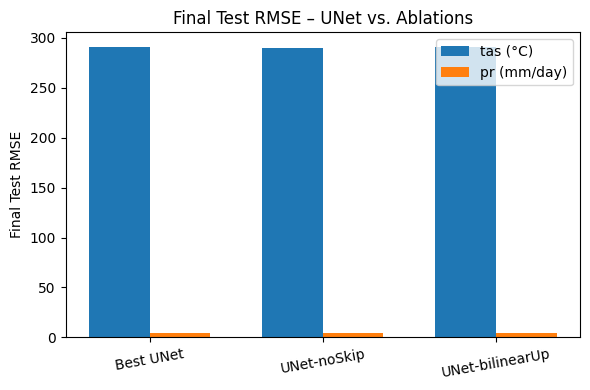

In [3]:
labels        = list(MODELS.keys())
tas_test_rmse = [TEST_ROWS[l]["test/tas/rmse"] for l in labels]
pr_test_rmse  = [TEST_ROWS[l]["test/pr/rmse"]  for l in labels]

x = range(len(labels)); w = 0.35
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar([i - w/2 for i in x], tas_test_rmse, width=w, label="tas (°C)")
ax.bar([i + w/2 for i in x], pr_test_rmse,  width=w, label="pr (mm/day)")
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=10)
ax.set_ylabel("Final Test RMSE")
ax.set_title("Final Test RMSE – UNet vs. Ablations")
ax.legend(); fig.tight_layout()

p = FIG_DIR / "bar_final_test_rmse.png"
fig.savefig(p, dpi=300); print("Saved →", p.relative_to(ROOT_DIR))
plt.show()


/tmp/ipykernel_41412/1857798847.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved → visualization/figures/unet_ablation/line_val_rmse_vs_epoch_noskip.png


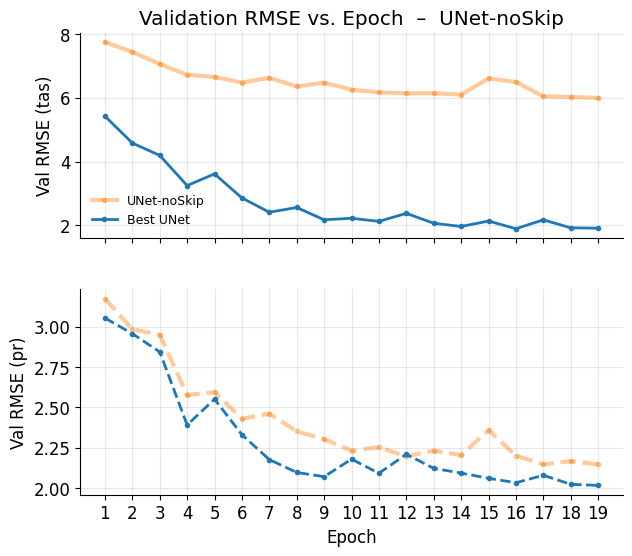

Saved → visualization/figures/unet_ablation/line_val_rmse_vs_epoch_bilinearUp.png


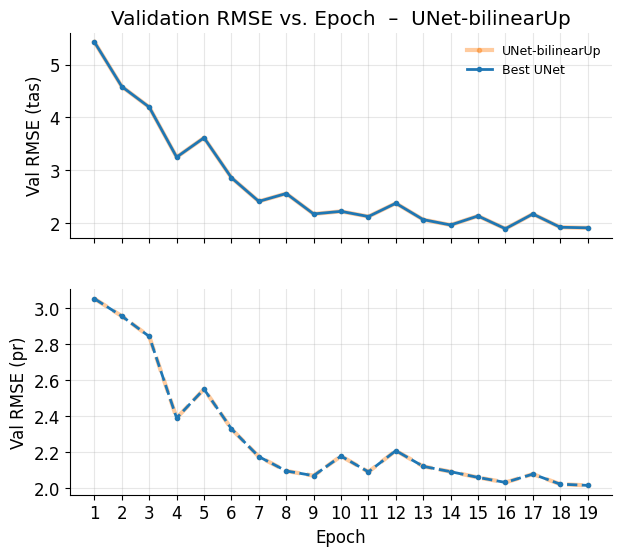

In [7]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 4  —  Val-RMSE-vs-Epoch (two separate figures, transparent underlay)
# ────────────────────────────────────────────────────────────────────────────────
import matplotlib as mpl
mpl.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.grid": True, "grid.alpha": 0.3,
    "lines.linewidth": 2.0, "font.size": 12,
})

pairs = [
    ("UNet-noSkip",    "line_val_rmse_vs_epoch_noskip.png"),
    ("UNet-bilinearUp","line_val_rmse_vs_epoch_bilinearUp.png"),
]

ms = 3   # tiny marker size
for ab_label, fname in pairs:
    best_df = RAW_LOGS["Best UNet"]
    abl_df  = RAW_LOGS[ab_label]

    fig, (ax_tas, ax_pr) = plt.subplots(2, 1, figsize=(7, 6), sharex=True,
                                        gridspec_kw={"hspace": 0.25})

    # === tas panel ===
    # Draw ablation first: wide + semi-transparent
    ax_tas.plot(abl_df["epoch"], abl_df["val/tas/rmse"],
                color="tab:orange", lw=3, alpha=0.4,
                marker="o", markersize=ms, markevery=1,
                label=ab_label)
    # Draw Best UNet on top: thinner & opaque
    ax_tas.plot(best_df["epoch"], best_df["val/tas/rmse"],
                color="tab:blue", lw=2,
                marker="o", markersize=ms, markevery=1,
                label="Best UNet")

    # === pr panel ===
    ax_pr.plot(abl_df["epoch"], abl_df["val/pr/rmse"],
               color="tab:orange", lw=3, alpha=0.4,
               marker="o", markersize=ms, markevery=1,
               linestyle="--", label=ab_label)
    ax_pr.plot(best_df["epoch"], best_df["val/pr/rmse"],
               color="tab:blue", lw=2,
               marker="o", markersize=ms, markevery=1,
               linestyle="--", label="Best UNet")

    # Styling
    ax_tas.set_ylabel("Val RMSE (tas)")
    ax_tas.set_title(f"Validation RMSE vs. Epoch  –  {ab_label}")
    ax_tas.legend(frameon=False, fontsize=9)

    ax_pr.set_ylabel("Val RMSE (pr)")
    ax_pr.set_xlabel("Epoch")

    fig.tight_layout()

    save_path = FIG_DIR / fname
    fig.savefig(save_path, dpi=300)
    print("Saved →", save_path.relative_to(ROOT_DIR))
    plt.show()


Saved → visualization/figures/unet_ablation/bar_time_std_mae.png


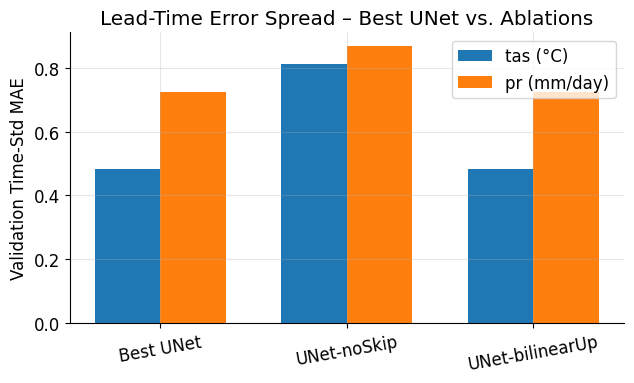

In [10]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 5  —  Time-Std MAE bar chart  (include Best UNet)
# ────────────────────────────────────────────────────────────────────────────────
labels_all = ["Best UNet", "UNet-noSkip", "UNet-bilinearUp"]

tas_std = [VAL_ROWS[l]["val/tas/time_std_mae"] for l in labels_all]
pr_std  = [VAL_ROWS[l]["val/pr/time_std_mae"]  for l in labels_all]

x = range(len(labels_all)); w = 0.35
fig, ax = plt.subplots(figsize=(6.5, 4))

ax.bar([i - w/2 for i in x], tas_std, width=w, label="tas (°C)",
       color="tab:blue")
ax.bar([i + w/2 for i in x], pr_std,  width=w, label="pr (mm/day)",
       color="tab:orange")

ax.set_xticks(x)
ax.set_xticklabels(labels_all, rotation=10)
ax.set_ylabel("Validation Time-Std MAE")
ax.set_title("Lead-Time Error Spread – Best UNet vs. Ablations")
ax.legend()
fig.tight_layout()

p = FIG_DIR / "bar_time_std_mae.png"
fig.savefig(p, dpi=300)
print("Saved →", p.relative_to(ROOT_DIR))
plt.show()



/tmp/ipykernel_41412/64148702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved → visualization/figures/unet_ablation/delta_rmse_UNet_noSkip.png


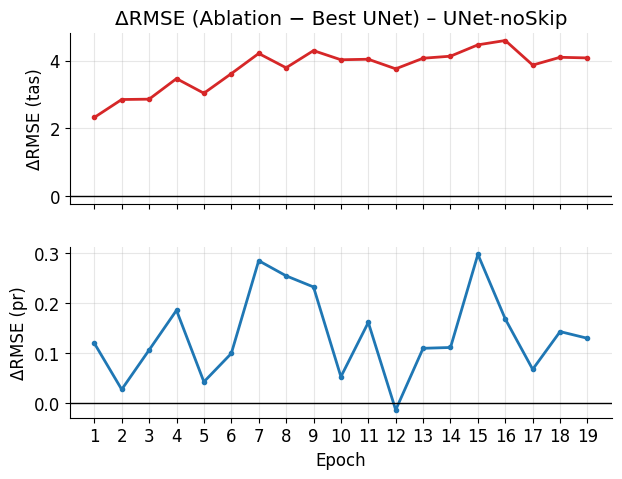

Saved → visualization/figures/unet_ablation/delta_rmse_UNet_bilinearUp.png


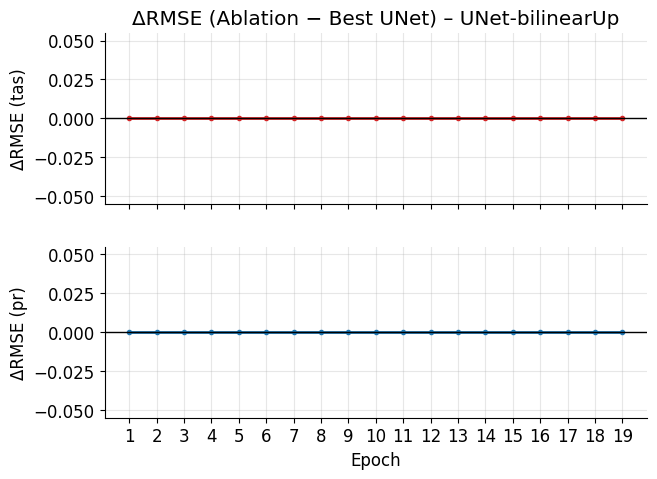

In [8]:
best_df  = RAW_LOGS["Best UNet"]
epoch    = best_df["epoch"]

for ab_label in ("UNet-noSkip", "UNet-bilinearUp"):
    abl_df = RAW_LOGS[ab_label]

    fig, (ax_t, ax_p) = plt.subplots(2, 1, figsize=(7, 5), sharex=True,
                                     gridspec_kw={"hspace": 0.25})
    delta_tas = abl_df["val/tas/rmse"] - best_df["val/tas/rmse"]
    delta_pr  = abl_df["val/pr/rmse"]  - best_df["val/pr/rmse"]

    ax_t.plot(epoch, delta_tas, color="tab:red", marker="o", markersize=3)
    ax_p.plot(epoch, delta_pr,  color="tab:blue", marker="o", markersize=3)

    for ax, title in zip((ax_t, ax_p), ("tas", "pr")):
        ax.axhline(0, color="k", linewidth=1)
        ax.set_ylabel(f"ΔRMSE ({title})")

    ax_t.set_title(f"ΔRMSE (Ablation − Best UNet) – {ab_label}")
    ax_p.set_xlabel("Epoch")

    fig.tight_layout()
    fname = f"delta_rmse_{ab_label.replace('-', '_')}.png"
    p = FIG_DIR / fname
    fig.savefig(p, dpi=300); print("Saved →", p.relative_to(ROOT_DIR))
    plt.show()


In [9]:
print("Saved figures:")
for p in sorted(FIG_DIR.glob("*.png")):
    print(" •", p.relative_to(ROOT_DIR))


Saved figures:
 • visualization/figures/unet_ablation/bar_final_test_rmse.png
 • visualization/figures/unet_ablation/bar_time_std_mae.png
 • visualization/figures/unet_ablation/delta_rmse_UNet_bilinearUp.png
 • visualization/figures/unet_ablation/delta_rmse_UNet_noSkip.png
 • visualization/figures/unet_ablation/line_val_rmse_vs_epoch.png
 • visualization/figures/unet_ablation/line_val_rmse_vs_epoch_bilinearUp.png
 • visualization/figures/unet_ablation/line_val_rmse_vs_epoch_noskip.png
